In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import sqlalchemy
import yfinance as yf
import yahoo_fin.stock_info as si
import os

In [2]:
# Using the Pandas read_csv funcion and the Path module, 
# read "sample_esg.csv" file into a Pandas DataFrame
esg_df = pd.read_csv(
    Path("sp500_sustainability_scores.csv")
)

# Review the DataFrame
esg_df.head()

,Unnamed: 0,palmOil,controversialWeapons,gambling,socialScore,nuclear,furLeather,alcoholic,gmo,catholic,...,coal,pesticides,adult,percentile,peerGroup,smallArms,environmentScore,governancePercentile,militaryContract,company_ticker
0,Value,False,False,False,8.65,False,False,False,False,True,...,False,False,False,10.48,Pharmaceuticals,False,0.34,0,False,A
1,Value,False,False,False,12.31,False,False,False,False,False,...,False,False,False,58.47,Transportation,False,11.53,0,False,AAL
2,Value,False,False,False,9.17,False,False,False,False,False,...,False,False,False,5.74,Retailing,False,0.10,0,False,AAP
3,Value,False,False,False,6.86,False,False,False,False,False,...,False,False,False,12.87,Technology Hardware,False,0.65,0,False,AAPL
4,Value,False,False,False,16.92,False,False,False,False,True,...,False,False,False,53.78,Pharmaceuticals,False,1.12,0,False,ABBV


In [3]:
# Create the connection string for your SQLite database
database_connection_string = 'sqlite:///'

# Pass the connection string to the SQLAlchemy create_engine function
engine = sqlalchemy.create_engine(database_connection_string)

# Confirm that the database engine was created.
engine

Engine(sqlite:///)

In [4]:
esg_df.to_sql(
    'esg_score_info', #New table name
    engine, 
    index=False, 
    if_exists='replace'
)

# Confirm that the table was created by calling the table_names function
engine.table_names()

/Users/puntepbhayakaporn/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  if __name__ == '__main__':


['esg_score_info']

In [30]:
# e_score = 10
# s_score = 10
# g_score = 8

# Create and execute a query to return all columns for the 10 highest credit scores.
# query1 = """
# SELECT company_ticker, environmentScore, socialScore, governanceScore
# FROM esg_score_info
# WHERE environmentScore >= """+str(e_score)+""" AND socialScore >= """+str(s_score)+""" AND governanceScore >= """+str(g_score)+""";
# """

## , environmentScore, socialScore, governanceScore

# Call on the database engine to execute the query
# results = engine.execute(query1)

# List of the results of the database query
# list(results)

In [31]:
e_score = 10
s_score = 10
g_score = 8

# Create and execute a query to return all columns for the 10 highest credit scores.
query1 = """
SELECT company_ticker, environmentScore, socialScore, governanceScore
FROM esg_score_info
WHERE environmentScore >= """+str(e_score)+""" AND socialScore >= """+str(s_score)+""" AND governanceScore >= """+str(g_score)+""";
"""

# read in your SQL query results using pandas
esg_df = pd.read_sql(query1, con=engine)

# return your first five rows
esg_df.head()

,company_ticker,environmentScore,socialScore,governanceScore
0,CTRA,23.39,14.01,9.28
1,CVX,22.42,10.86,9.95
2,GE,14.09,15.04,11.58
3,MMM,13.20,13.60,8.08
4,MOS,16.30,12.03,8.55


In [76]:
esg_ticker = esg_df['company_ticker']

#Download historical data for S&P 500
sp500_hist_data = yf.download(list(esg_ticker), start="2020-01-01", end="2020-04-30")

#Count the number of column fetched
column_count = (len(sp500_hist_data.columns))/6

#Fetch only the "Adjusted Closing Price" from the data frame
sp500_hist_data_closing = sp500_hist_data.iloc[:,0:int(column_count)]

#Print the data frame to make sure the data is fetched correctly
sp500_hist_data_closing

[*********************100%***********************]  10 of 10 completed


Adj Close                                                \
                 CTRA         CVX         GE         MMM        MOS   
Date                                                                  
2020-01-02  15.914399  108.060585  94.659439  166.588989  21.005356   
2020-01-03  15.960581  107.686829  94.976822  165.154449  20.348633   
2020-01-06  16.089890  107.321960  96.325706  165.311798  20.348633   
2020-01-07  16.182255  105.951515  95.611588  164.645432  20.505463   
2020-01-08  15.563415  104.741257  94.738792  167.172028  20.691694   
...               ...         ...        ...         ...        ...   
2020-04-23  18.630581   78.146156  51.784786  134.786209  11.039924   
2020-04-24  19.002451   78.335220  49.719746  137.279663  11.138230   
2020-04-27  19.606731   80.766029  51.069958  143.489929  11.384001   
2020-04-28  19.095417   80.946098  54.008667  147.188065  11.334846   
2020-04-29  19.309240   85.186516  52.261330  145.927338  11.796891   

                                                                    
                  MRO        NUE         TDG        TSN        XOM  
Date                                                                
2020-01-02  13.302160  52.096638  567.440002  85.615990  61.174892  
2020-01-03  13.370227  51.406689  577.840027  86.196457  60.683086  
2020-01-06  13.574428  50.971916  584.799988  85.787277  61.149014  
2020-01-07  13.409122  50.858498  587.000000  84.540665  60.648575  
2020-01-08  12.913206  50.735630  585.630005  85.064049  59.733971  
...               ...        ...         ...        ...        ...  
2020-04-23   4.728540  36.086987  314.279999  58.297215  38.028343  
2020-04-24   4.816467  36.230492  304.920013  56.459267  38.273407  
2020-04-27   4.738310  38.746628  317.450012  57.129353  38.457203  
2020-04-28   4.875086  38.737064  336.649994  60.116013  39.358677  
2020-04-29   5.715281  40.660038  371.179993  60.594639  41.537971  

[82 rows x 10 columns]

In [82]:
#Create the "Custom_Index" column to calculate the average price of all the filtered stock
sp500_hist_data_closing['custom_index'] = sp500_hist_data_closing.mean(axis=1)

#Select only the average price of all fetch stocks
position_of_avg_price = len(sp500_hist_data_closing.columns)

#Select only date and price
sp500_hist_data_closing_only = sp500_hist_data_closing.iloc[:,int(position_of_avg_price)-1]

#Print the data frame to make sure the data is fetched correctly
sp500_hist_data_closing_only

Date
2020-01-02    118.585845
2020-01-03    119.362380
2020-01-06    120.168061
2020-01-07    119.935311
2020-01-08    119.698405
                 ...    
2020-04-23     74.580874
2020-04-24     73.617496
2020-04-27     76.283815
2020-04-28     79.230993
2020-04-29     83.416924
Name: (custom_index, ), Length: 82, dtype: float64

<AxesSubplot:title={'center':'The Price Index of Stock Filtered'}, xlabel='Date', ylabel='Price Index'>

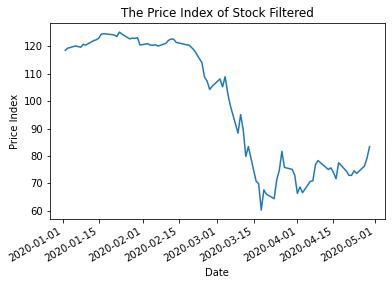

In [89]:
#Plot the data frame
sp500_hist_data_closing_only.plot(title="The Price Index of Stock Filtered", xlabel="Date", ylabel="Price Index")

In [ ]:
# upload my work on github correctly [checked]

# csv name and column name to pull the info
# --> table and column name for esg
# --> table and column name for industry

# integrate the SQL code with streamlit